# Looking Predictive Model

En este cuaderno se tratara de buscar el mejor modelo de aprendizaje supervisado para tratar de predecir el porcentaje de que una canción sea hit, acorde a las caracteristicas que hemos obtenido.

In [15]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
import matplotlib.pyplot as plt
import joblib
plt.rcParams['figure.figsize'] = 8, 6

- Definimos función que usaremos para extraer las características necesarias de una canción para hacer una predicción de probabilidad de ser un *hit* dado un título y artistas.

In [16]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

# sp_cid: Sustituir por spotify client id (str)
# sp_secret: Sustituir por spotify secret id (str)
client_credentials_manager = SpotifyClientCredentials(client_id='sp_cid', client_secret='sp_secret') 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, requests_timeout=50)

def find_song():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        track_feat = sp.audio_features(id_track)
        song = [[track_feat[0]["danceability"], track_feat[0]["energy"], track_feat[0]["key"],
        track_feat[0]["loudness"], track_feat[0]["mode"], track_feat[0]["speechiness"],
        track_feat[0]["acousticness"], track_feat[0]["instrumentalness"], track_feat[0]["liveness"],
        track_feat[0]["valence"], track_feat[0]["tempo"],track_feat[0]["time_signature"],
                track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Se lee dataframe y se realiza *split* para los entrenamientos y test.

In [17]:
df_songs = pd.read_csv("../Data/fusion_songs_1958_2020_to_train.csv")

In [18]:
df_songs.head()

,artist,title,id,year_chart,date_chart,release_date,collaboration,rank,weeks,isNew,peakPos,lastPos,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,duration_ms,popularity_artist,popularity_song,genres,album,label,song_lyrics,target
0,Nat King Cole,Time And The River,7vu51HpremcwWKhBhVccDB,1960.0,1960-03-21,1965-08-01,False,99.0,8.0,False,30.0,85.0,0.415,0.249,10,-13.619,1,0.0295,0.893,0.000008,0.1190,0.3520,83.912,4,139573,68,13,"['adult standards', 'lounge', 'soul', 'vocal j...",Looking Back,CAPITOL CATALOG MKT (C92),NaN,1
1,Keyshia Cole,Last Night,3Cn1FSSTXeQ7hCfrbizrD0,2007.0,2007-06-30,2007-01-01,True,39.0,22.0,False,10.0,31.0,0.916,0.849,3,-5.034,0,0.0639,0.166,0.000193,0.0859,0.9740,121.002,4,255773,71,57,"['dance pop', 'deep pop r&b', 'hip pop', 'neo ...",Just Like You,Geffen,"Last night, I couldn't even get an answer\nI t...",1
2,Jónsi,Around Us,1VYXp8Y1GUyY04wWhlAfeE,NaN,NaN,2010-11-29,False,NaN,NaN,NaN,NaN,NaN,0.324,0.641,3,-9.136,1,0.0411,0.105,0.009490,0.2290,0.0666,139.938,4,315120,55,13,"['compositional ambient', 'icelandic pop', 'po...",Around Us,Parlophone UK,NaN,0
3,Cassowary,She Funked Me,5x6KuClP6lLCvgjXUbLKGb,NaN,NaN,2019-11-19,False,NaN,NaN,NaN,NaN,NaN,0.741,0.646,2,-6.897,0,0.0314,0.234,0.793000,0.0926,0.6160,118.018,4,221426,31,5,[],She Funked Me,Fat Possum,NaN,0
4,Ludwig van Beethoven,"Beethoven: Symphony No. 2 in D Major, Op. 36: ...",6WKXJwgtSdkDj3fRga7VWy,NaN,NaN,2003,True,NaN,NaN,NaN,NaN,NaN,0.326,0.187,2,-19.562,1,0.0459,0.918,0.651000,0.2660,0.3090,78.314,4,373280,74,34,"['classical', 'classical era', 'early romantic...",Beethoven : Symphonies 1-9,Warner Classics,NaN,0


In [19]:
X = df_songs.loc[:,"danceability":"duration_ms"]
y = df_songs.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

Atendiendo a las características del dataset, y dado el tipo de problema tabular donde como se pudo observar en el cuaderno 1_hit_analysis.ipynb, tenemos hits que se mueven en un rango alto de valores para cada una de sus características, vemos con bastantes posibilidades de una buena predicción al uso de algoritmos *random forest*, a partir de este, iremos utilizando cada vez modelos más avanzados para ver si se consiguen unas mejores predicciones.

## Random Forest
- Como se ha explicado, el primer modelo que usaremos de aprendizaje supervisado, es *random forest*

In [20]:
from sklearn.ensemble import RandomForestClassifier

- Probamos el modelo de *random forest* con la configuración por defecto dada por *sklearn*

In [21]:
forest = RandomForestClassifier (random_state=42)

In [22]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 29.6 s


0.7461840041819132

Vemos el *score* obtenido utilizando *cross validation* ya que sin usar esta tecnica, los modelos basados en arboles de decisión tenderan al sobrenetrenamiento y serán poco generalizables.

- La función anterior no almacena el entrenamiento generado, por ello entrenamos *random forest* con la configuración por defecto, pero ahora sobre todos los datos de entrenamiento. La idea en los siguientes pasos, será conseguir el mayor *score* posible usando *cross validation* y modificando los hiperparametros, una vez obtenido el mejor *score*, se entrenará el modelo con todo el dataset de entrenamiento.

In [23]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [24]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7459
Precisión sobre datos de train: 0.9996


Como se ha comentado, los modelos basados en árboles de decisión tenderán al sobreentrenamiento, por lo que la mejor manera es configurarlos utilizando las técnicas de *cross validation* y obtener el mayor *score* posible, que aunque los resultados obtenidos con todo el dataset de entrenamiento den más bajos, sean modelos más generalizables.

- El número de estimadores influencia bastante en la rapidez de entrenamiento del modelo, ya que indica el número de árboles usados en el modelo, pero este valor no debe de ser excesivamente alto para obtener un buen *score*. Para ello calcularemos el *score* para diferentes números de estimadores con un *cross val* de 5 que es el que toma por defecto la función, y analizaremos los resultados obtenidos.

In [12]:
param_range = [30,40,50,60,90,100,130,150,200,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [13]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.7350757971772085 en train: 0.9988630423418714
n_estimators 40 en test: 0.7382645060115003 en train: 0.9992877679038161
n_estimators 50 en test: 0.7411134343962363 en train: 0.9995230005227391
n_estimators 60 en test: 0.7408782017773131 en train: 0.9995360690015682
n_estimators 90 en test: 0.7460794563512807 en train: 0.9996079456351282
n_estimators 100 en test: 0.7440146366962885 en train: 0.9996144798745427
n_estimators 130 en test: 0.7479874542603241 en train: 0.9996144798745427
n_estimators 150 en test: 0.7462885520125457 en train: 0.9996144798745427
n_estimators 200 en test: 0.7467328802927339 en train: 0.9996144798745427
n_estimators 300 en test: 0.7485363303711446 en train: 0.9996144798745427


Tomando el valor medio de cada resultado, ya que por cada prueba obtendremos 5 resultados que son las 5 partes en las que se divide el dataset, según lo indicado con un *cross val* de 5. Vemos que aumentando el numero de estimadores las mejoras en el modelo son casi imperceptibles, se mantienen casi constante con pequeñas oscilaciones, incluso bajando el *score* de los resultados en test en algunos casos. Por lo que para entrenamientos del modelo no suele ser necesario un uso muy alto del número de estimadores que lo único que harán es aumentar el tiempo de entrenamiento.

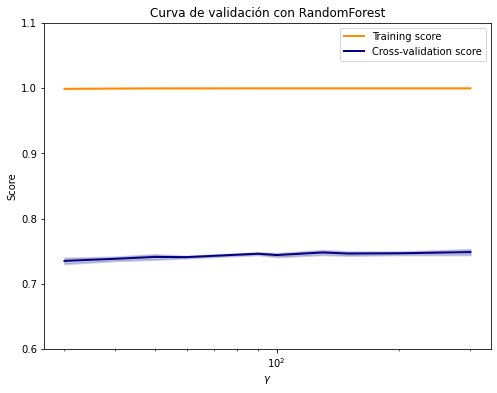

In [14]:
train_scores_mean = np.mean(train_score, axis=1)
train_scores_std = np.std(train_score, axis=1)
test_scores_mean = np.mean(test_score, axis=1)
test_scores_std = np.std(test_score, axis=1)

plt.title("Curva de validación con RandomForest")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.6, 1.1)
lw = 2
plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Aqui observamos graficamente los resultados obtenidos anteriormente.

- A continuación, vamos a tratar de mejorar el *score* de nuestro modelo y para ello usaremos la función de RandomizedSearchCV que dado unos rangos en los parámetros que indicaremos a continuación, ira probando combinaciones aleatorias hasta un número de pruebas elegido por nosotros. También existe la técnica de Gridsearch que prueba todas las combinaciones, pero esto haría que el proceso durase varios días, o definir un rango de valores más pequeño, es complejo poder afinar en un rango pequeño que nos dé buenos resultados, por lo que usamos esta técnica para tratar de encontrar una buena combinación de hiperparametros. La siguiente prueba ha llevado un total de 478.4 min

In [15]:
forest = RandomForestClassifier (random_state=42)

In [18]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


Seleccionamos para la prueba un *cross val* de 5, definimos random_state, cantidad de mensajes que salga y uso de todas las CPUs disponibles.

In [19]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [20]:
forest_random.fit(X_train, y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 27.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 41.9min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 56.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 72.3min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 91.4min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 112.8min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 135.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 159.6min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 185.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 214.2min
[Parallel(n_jobs=-1)]: Done 9097 tasks    

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

- A continuación se puede ver la mejor configuración encontrada para las iteraciones probadas y el *score* obtenido para esa configuración.

In [21]:
forest_random.best_params_

{'n_estimators': 123,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_leaf_nodes': None,
 'max_features': 4,
 'max_depth': 20}

In [22]:
forest_random.best_score_

0.7483272347098797

Respecto de la configuración por defecto donde se obtenía un *score* de 0.746 hemos conseguido una mejoría muy pequeña. Tomaremos esta nueva configuración la que mejor ha clasificado para nuestro dataset de entrenamiento.

- La siguiente gráfica es bastante interesante, ya que muestra la importancia de las características predictivas respecto de otras, es importante tener en cuenta esto, ya que las características que tengan poca importancia, lo son, pero respecto de las otras, lo que no quiere decir que si eliminamos estas de los entrenamientos se mantengan unos *scores* como los que hemos obtenido o que mejore la predicción del modelo.

In [23]:
best_forest = forest_random.best_estimator_

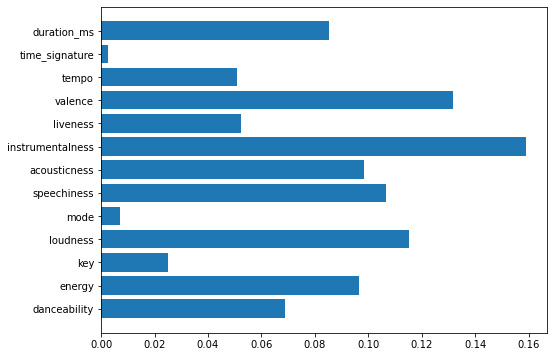

In [24]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_forest.feature_importances_);

- Con la mejor configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos resultados obtenidos, tanto con los datos de entrenamiento como con los de test.

In [25]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=123,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [26]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.7478
Precisión sobre datos de train: 0.9225


Podemos ver como el *score* con los datos de entrenamiento, ha decrecido con respecto al modelo inicial, pero en cambio hemos mejorado ligeramente el resultado sobre los resultados de test, en este caso 0.002 muy poco, pero hemos encontrado un modelo más generalizable capaz de predecir que veremos como se comporta en el cuaderno 4 con nuevos datos.

- En este punto almacenaremos nuestro modelo obtenido, para su posterior uso

In [27]:
filename = '../Models/forest_model_random.pkl'

In [28]:
joblib.dump(best_forest, filename)

['../Models/forest_model_random.pkl']

In [29]:
best_forest = joblib.load(filename) 

- Por último representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

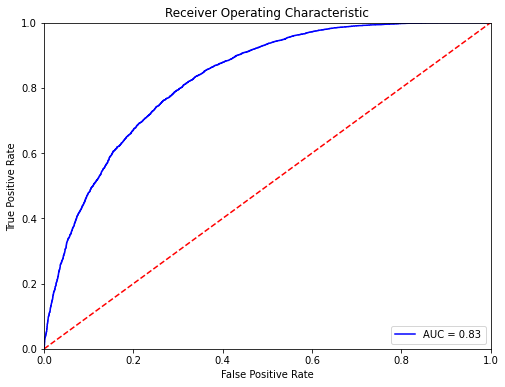

In [30]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Como se puede observar tenemos para este modelo un AUC=0.83, por lo que podemos hablar de un buen clasificador con buena discriminación.

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [61]:
score = best_forest.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 54.12948614168127


## AdaBoost
-  El segundo modelo que vamos a utilizar es AdaBoost que utiliza las técnicas de *boosting*, un modelo más avanzado que el anterior. 

In [25]:
from sklearn.ensemble import AdaBoostClassifier

In [26]:
ada_clf = AdaBoostClassifier(random_state=42)

- El proceso llevado a cabo es similar al del modelo anterior, veremos como funciona el modelo con la configuración por defecto y trataremos de buscar una mejor configuración de hiperparametros que nos haga tener unos mejores resultados utilizando *cross validation* y un modelo más generalizable.

In [27]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 7.09 s


0.7145582854155776

In [28]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=42)

In [29]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7137
Precisión sobre el juego de train: 0.7204


Como se puede observar, el modelo no es muy bueno con la configuración por defecto con respecto a *random forest*

- Vamos a analizar como influye el número de estimadores al modelo

In [36]:
param_range = [25,30,40,50,60,90,100,130]
train_score, test_score= validation_curve(
                                ada_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [37]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 25 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 30 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 40 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 50 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 60 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 90 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 100 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 130 en test:',test_score[7].mean(),'en train:',train_score[7].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 25 en test: 0.7041557762676425 en train : 0.7100823314166231
n_estimators 30 en test: 0.7046001045478307 en train: 0.712107945635128
n_estimators 40 en test: 0.7107422895974909 en train: 0.7183677469942499
n_estimators 50 en test: 0.7145582854155776 en train: 0.7216806063774176
n_estimators 60 en test: 0.7166753789858861 en train: 0.7242093570308417
n_estimators 90 en test: 0.7180345007841088 en train: 0.7269537375849451
n_estimators 100 en test: 0.7186617877679039 en train: 0.7276071615263984
n_estimators 130 en test: 0.7197334030318872 en train: 0.7299856246732881


- Definimos *Grid* de parámetros para buscar la mejor combinación 

In [15]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 19)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [round(float(x),2) for x in np.linspace(0.05, 1., num = 20)]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, None]}


- AdaBoost utiliza las técnicas de boosting por defecto sobre árboles de decisión, pero se podría aplicar boosting sobre cualquier estimador, como modelos lineales e incluso redes neuronales. Para este tipo de problemas tabulares lo mejor es usar árboles de decisión. Para hacer el *randomSearch*, ya que vamos a modificar tanto parámetros del modelo adaBoost como del árbol de decisión es necesario pasarle el modelo del estimador base que aunque por defecto sea árbol de decisión si no lo indicamos no podremos hacer un randomSearch sobre el árbol también.

In [16]:
from sklearn.tree import DecisionTreeClassifier

In [17]:
base_estimator = DecisionTreeClassifier(random_state=42)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=42)

In [18]:
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 3250, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [19]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 3250 candidates, totalling 16250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 40.7min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 59.6min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 81.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 104.9min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 139.2min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 171.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 208.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 252.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 297.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 350.6min
[Parallel(n_jobs=-1)]: Done 9097 tasks  

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

- A continuación observamos la mejor configuración de hiperparametros encontrada, para un mayor *score* obtenido para un *cross val* de 5.

In [20]:
ada_random.best_params_

{'n_estimators': 136,
 'learning_rate': 0.2,
 'base_estimator__min_samples_split': 10,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__max_leaf_nodes': 90,
 'base_estimator__max_features': 3,
 'base_estimator__max_depth': 110,
 'algorithm': 'SAMME'}

In [21]:
ada_random.best_score_

0.7483795086251961

Como se puede observar hemos mejorado el *score* un 0.034 con esta nueva configuración con respecto al modelo que usaba la configuración por defecto.

- A continuación se muestra como en el caso anterior de *random forest*, la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [22]:
best_ada = ada_random.best_estimator_

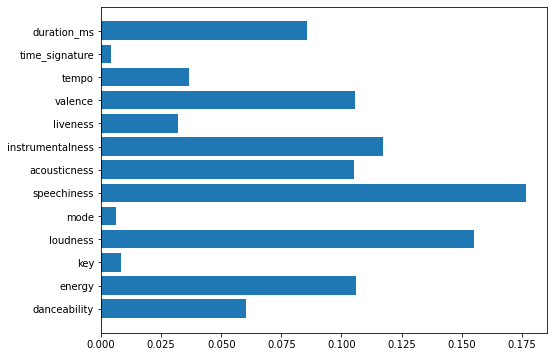

In [23]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_ada.feature_importances_);

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [25]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=110,
                                                         max_features=3,
                                                         max_leaf_nodes=90,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=10,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                              

In [26]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7436
Precisión sobre el juego de train: 0.7841


Podemos ver como el *score* con los datos de entrenamiento, ha aumentado con respecto al modelo inicial, también hemos mejorado el resultado sobre los resultados de test, en este caso 0.03, mejorando por tanto los resultados de entrenamiento y de test.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [2]:
filename = '../Models/ada_boost_model_random.pkl'

In [28]:
joblib.dump(best_ada, filename)

['../Models/ada_boost_model_random.pkl']

In [3]:
best_ada = joblib.load(filename) 

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

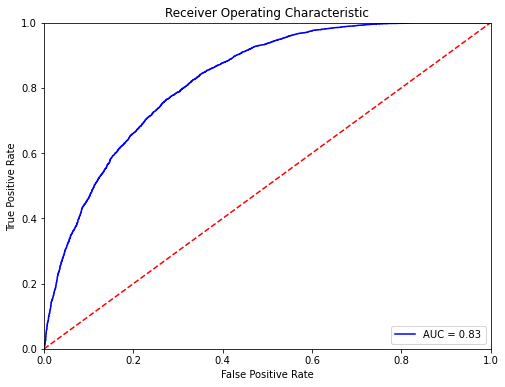

In [30]:
probs = best_ada.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Nos encontramos otra vez ante un buen modelo clasificador con un AUC=0.83

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [9]:
score = best_ada.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eillish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 51.011772084493714


## Gradient Boosting
- La siguiente técnica que utilizaremos será GradientBoosting, y para ello lo haremos usando la implementación de LightGBM, está junto XGBoost son las dos más extendidas, pero optaremos por LightGBM debido a su alta rapidez en los entrenamientos, del orden de 10 veces más rápidos que XGBoost, lo que nos permitirá hacer una búsqueda de hiperparametros más amplia, y los resultados que se obtienen con ambas implementaciones son bastante similares.

In [31]:
import lightgbm as lgb

In [32]:
lgb_clf =lgb.LGBMClassifier(random_state=42)

In [33]:
%%time
cross_val_score(lgb_clf, X_train,y_train, cv=5).mean()

Wall time: 1.22 s


0.7474385781495034

Como se puede apreciar LighGBM es extremadamente rapido en su entrenamiento

In [34]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [35]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7488
Precisión sobre el juego de train: 0.7862


Como se puede observar, por defecto ya somos capaces de obtener un buen *score* si lo comparamos con los modelos previamente probados

In [83]:
param_range = [60,90,100,150,200,250,300]
train_score, test_score= validation_curve(
                                lgb_clf,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [84]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 60 en test:',test_score[0].mean(),'en train :',train_score[0].mean())
print ('n_estimators 90 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 100 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 150 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 200 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 250 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 300 en test:',test_score[6].mean(),'en train:',train_score[6].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 60 en test: 0.7453998954521693 en train : 0.7767838473601673
n_estimators 90 en test: 0.7474908520648197 en train: 0.7888329848405645
n_estimators 100 en test: 0.7479090433873496 en train: 0.7929103502352326
n_estimators 150 en test: 0.7487454260324098 en train: 0.8095138525875587
n_estimators 200 en test: 0.7488499738630423 en train: 0.8258690538421328
n_estimators 250 en test: 0.7499477260846837 en train: 0.8415577626764245
n_estimators 300 en test: 0.7488499738630423 en train: 0.8551032409827496


- Definimos *grid* de parámetros sobre los que entrenar el modelo en busca del mejor resultado.

In [125]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 9)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [30, 45, 60, 75, 90, 105, 120, 135, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


- Lanzamos búsqueda aleatoria.

In [127]:
lgb_clf = lgb.LGBMClassifier(random_state=42)

In [128]:
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 20000, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [129]:
light_gbm_random.fit(X_train, y_train)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   41.8s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 25.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 35.8min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 42.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=42, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                              

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [130]:
light_gbm_random.best_params_

{'subsample_for_bin': 160000,
 'reg_lambda': 0.0,
 'reg_alpha': 0.9,
 'num_leaves': 70,
 'n_estimators': 150,
 'min_split_gain': 0.4,
 'min_child_samples': 31,
 'max_depth': 110,
 'learning_rate': 0.2,
 'boosting_type': 'dart'}

In [131]:
light_gbm_random.best_score_

0.752822791427078

Podemos observar que respecto a la configuración por defecto hemos conseguido una mejora de 0.005.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [132]:
best_light_gbm = light_gbm_random.best_estimator_

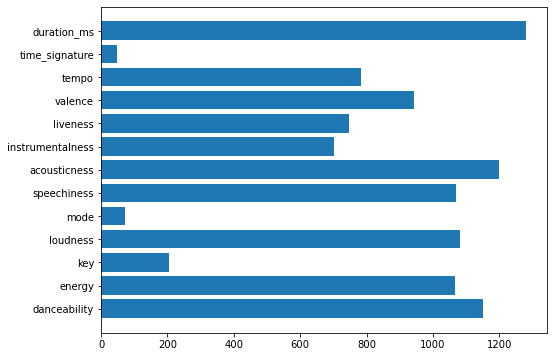

In [13]:
plt.barh(df_songs.loc[:,"danceability":"duration_ms"].columns, best_light_gbm.feature_importances_);

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [14]:
best_light_gbm.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.2, max_depth=110,
               min_child_samples=31, min_child_weight=0.001, min_split_gain=0.4,
               n_estimators=150, n_jobs=-1, num_leaves=70, objective=None,
               random_state=42, reg_alpha=0.9, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=160000, subsample_freq=0)

In [15]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_light_gbm.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_light_gbm.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.7518
Precisión sobre el juego de train: 0.8248


Hemos obtenido una mejora de 0.04 para los resultados de test y un aumento de 0.003 en los resultados de test. Hemos conseguido una mejor configuración que la de por defecto.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [10]:
filename = '../Models/light_gbm_model_random.pkl'

In [17]:
joblib.dump(best_light_gbm, filename)

['../Models/light_gbm_model_random.pkl']

In [11]:
best_light_gbm = joblib.load(filename) 

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

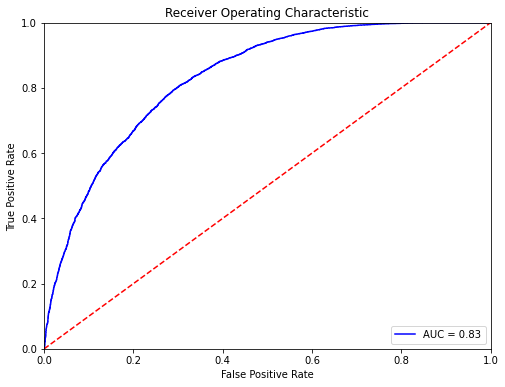

In [18]:
probs = best_light_gbm.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Obtennos un AUC=0.83, seguimos obteniendo buenos resultados.

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [57]:
score = best_light_gbm.predict_proba(find_song())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 48.32208301166033


## Conclusiones

Tras ver los resultados obtenidos para estos tres modelos, podemo observar que el que mejor resultado obtiene en la clasificación para los datos de test es light gbm con un 0.7518 seguido de *random forest* con un 0.7478 y por último Ada Boost con un 0.7436. Hemos conseguido resultados muy parecidos. En el cuaderno 4_model_testing podremos a prueba estos modelos, con canciones actuales y analizaremos cuál es capaz de predecir mejor para canciones actuales.

# Año como feature

En un principio no se pensó añadir el año como *feature*, ya que esto limitaría mucho la predicción en el futuro puesto que todas las nuevas predicciones que se hagan tomaran siempre la característica del año con 2020 como corte, entonces es una característica que impide que este tipo de modelos extrapolen en el tiempo, aunque podría dar buenos resultados en fechas actuales e incluso el próximo año, ya que la tendencia a corto plazo será similar a la vivida en el 2020, para ello vamos a entrenar nuestros modelos contando con esta característica y analizaremos los resultados.

- Primero definimos una función para poder hacer predicciones

In [36]:
def find_song_year():
    print("Artista: ", end="")
    artist = input()
    print("Titulo: ", end="")
    title = input()
    Searched = str (title + " " + artist)
    track = sp.search(Searched)
    try:
        id_track = track["tracks"]["items"][0]["uri"]
        track = sp.track(id_track)
        get_year = lambda date: parse(date, fuzzy=True).year
        year_realease = get_year(track["album"]["release_date"])
        track_feat = sp.audio_features(id_track)
        song = [[year_realease, track_feat[0]["danceability"], track_feat[0]["energy"],
                 track_feat[0]["key"],track_feat[0]["loudness"], track_feat[0]["mode"],
                 track_feat[0]["speechiness"],track_feat[0]["acousticness"],
                 track_feat[0]["instrumentalness"], track_feat[0]["liveness"],track_feat[0]["valence"],
                 track_feat[0]["tempo"],track_feat[0]["time_signature"],track["duration_ms"]]]
        
        print ("Canción elegida:",track["name"], "de", track["artists"][0]["name"] )
        return song
    except:
        print ("ERROR: Titulo no encontrado")

- Obtenemos el año del dataset para añadirlo como feature, para los *hits* tomaremos el año en el que han sido *hit* y para los no *hits* tomaremos el año de lanzamiento de la canción.

In [37]:
from dateutil.parser import parse

In [38]:
df_songs_year = pd.DataFrame.copy(df_songs)
get_year = lambda date: parse(date, fuzzy=True).year
df_songs_year.insert (12, "year", 0)
for i, item in df_songs_year.iterrows():
    if item['target']==0:
        year = get_year(item['release_date'])
    else:
        year = item['year_chart']
    df_songs_year.loc[i,'year'] = year

- Realizamos *split* del dataset para entrenamiento y test.

In [39]:
X = df_songs_year.loc[:,"year":"duration_ms"]
y = df_songs_year.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Random Forest
- Comenzaremos con el modelo de *random search*

El proceso llevado a cabo será igual que en los casos anteriores.

In [40]:
forest = RandomForestClassifier (random_state=32)

In [41]:
%%time
cross_val_score(forest,X_train,y_train,cv=5).mean()

Wall time: 27.9 s


0.8527966544694199

Podemos observar una importante subida en el acierto en el modelo al incluir esta característica.

In [42]:
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [43]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8539
Precisión sobre datos de train: 0.9999


Podemos ver como obtenemos un *score* que supera al del mejor *random forest* obtenido previamente, por 0.11 con la configuración por defecto.

In [19]:
param_range = [30,40,50,60,90,100,130,150,200,300]
train_score, test_score= validation_curve(
                                forest,
                                X = X_train, y = y_train, 
                                param_name = 'n_estimators', 
                               param_range=param_range,
                                scoring="accuracy")

In [20]:
print("Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)")
print ('n_estimators 30 en test:',test_score[0].mean(),'en train:',train_score[0].mean())
print ('n_estimators 40 en test:',test_score[1].mean(),'en train:',train_score[1].mean())
print ('n_estimators 50 en test:',test_score[2].mean(),'en train:',train_score[2].mean())
print ('n_estimators 60 en test:',test_score[3].mean(),'en train:',train_score[3].mean())
print ('n_estimators 90 en test:',test_score[4].mean(),'en train:',train_score[4].mean())
print ('n_estimators 100 en test:',test_score[5].mean(),'en train:',train_score[5].mean())
print ('n_estimators 130 en test:',test_score[6].mean(),'en train:',train_score[6].mean())
print ('n_estimators 150 en test:',test_score[7].mean(),'en train:',train_score[7].mean())
print ('n_estimators 200 en test:',test_score[8].mean(),'en train:',train_score[8].mean())
print ('n_estimators 300 en test:',test_score[9].mean(),'en train:',train_score[9].mean())

Numero de estimadores para un Cross_val 5 (test) y para todo dataset de entrenamiento (train)
n_estimators 30 en test: 0.8487715629900681 en train: 0.9987911657083115
n_estimators 40 en test: 0.848980658651333 en train: 0.999470726607423
n_estimators 50 en test: 0.8495556717198118 en train: 0.9996667537898588
n_estimators 60 en test: 0.8507579717720859 en train: 0.9997582331416623
n_estimators 90 en test: 0.8517773131207527 en train: 0.9998562467328803
n_estimators 100 en test: 0.8524830109775221 en train: 0.9998693152117093
n_estimators 130 en test: 0.8540512284370099 en train: 0.9998693152117093
n_estimators 150 en test: 0.8517773131207527 en train: 0.999875849451124
n_estimators 200 en test: 0.8529534762153685 en train: 0.999875849451124
n_estimators 300 en test: 0.8522739153162572 en train: 0.999875849451124


Podemos observar que sucede lo mismo que cuando no incluíamos el tiempo como *feature*, por tanto tenderemos a no usar unos números de estimador muy altos.

- Definimos *grid* con rangos de parámetros.

In [28]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13,14]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 90)]
max_leaf_nodes.append(None)
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               "max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 'auto'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'max_leaf_nodes': [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 100, None]}


- Realizamos búsqueda aleatoria

In [29]:
forest = RandomForestClassifier (random_state=32)

In [30]:
forest_random = RandomizedSearchCV(estimator = forest, param_distributions = param_grid, n_iter = 3500, cv = 5, verbose=2, random_state=42, n_jobs = -1)

In [31]:
forest_random.fit(X_train,y_train)

Fitting 5 folds for each of 3500 candidates, totalling 17500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   37.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 26.1min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 39.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 52.0min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 66.6min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 84.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 102.4min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 124.2min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 147.4min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 173.4min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 202.0min
[Parallel(n_jobs=-1)]: Done 9097 tasks    

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [32]:
forest_random.best_params_

{'n_estimators': 43,
 'min_samples_split': 2,
 'min_samples_leaf': 5,
 'max_leaf_nodes': None,
 'max_features': 4,
 'max_depth': 30}

In [33]:
forest_random.best_score_

0.8541296393099843

Podemos observar que la mejora con respecto al modelo con valores por defecto, es muy leve.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [ ]:
best_forest = forest_random.best_estimator_

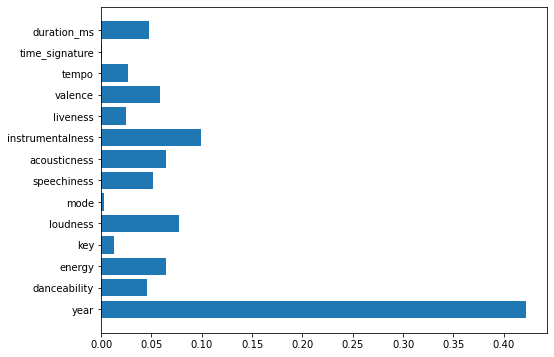

In [39]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_forest.feature_importances_);

Podemos observar la cantidad de peso que tiene el año con respecto a las demás, en el cuaderno 4_model_testing, veremos como se comporta para canciones actuales.

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [36]:
best_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=30, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=43,
                       n_jobs=None, oob_score=False, random_state=32, verbose=0,
                       warm_start=False)

In [33]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_forest.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_forest.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8545
Precisión sobre datos de train: 0.9348


Podemos observar como para esta configuración tenemos unos resultados peores tanto en entrenamiento y prácticamente muy similares en test. Tomaremos este modelo, ya que al tener algo de mejor *score* con *cross validation* tendera a generalizar mejor.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [35]:
filename = '../Models/forest_model_random_year.pkl'

In [22]:
joblib.dump(best_forest, filename)

['../Models/forest_model_random_year.pkl']

In [36]:
best_forest = joblib.load(filename) 

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

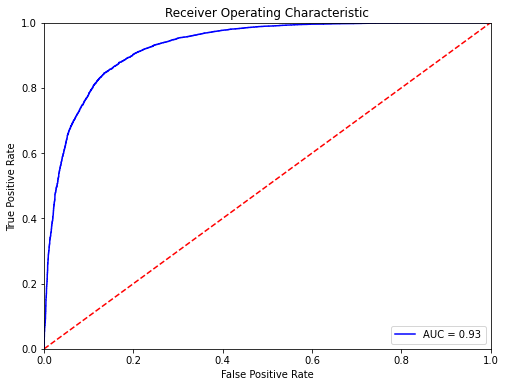

In [37]:
probs = best_forest.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Como ya se ha podido ver en los resultados de test, ahora gráficamente vemos que obtenemos una curva con un AUC=0.93, por lo que hablamos de un mejor clasificador.

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [56]:
score = best_forest.predict_proba(find_song_year())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 33.78738509552464


## AdaBoost
- Utilizaremos AdaBoost para entrenar el dataset

In [44]:
ada_clf = AdaBoostClassifier(random_state=32)

In [45]:
%%time
cross_val_score(ada_clf,X_train,y_train,cv=5).mean()

Wall time: 7.38 s


0.8401986408782017

Como para *random forest* obtenemos mejores resultados que cuando no incluíamos el año como característica.

In [46]:
ada_clf.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=32)

In [47]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(ada_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(ada_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8360
Precisión sobre el juego de train: 0.8438


- Definimos el *grid* de entrenamiento y se lanza la búsqueda de la mejor combinación de hiperparametros.

In [31]:
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 10)]
# Numero de caracteristicas proporcionadas a cada arbol
max_features = [1,2,3,4,5,6,7,8,9,10,11,12,13]
max_features.append('auto')
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimo valor para separar en subnodos
min_samples_split = [2, 5, 10]
# Minimo numero de muestras necesarias en hoja despues de dividir
min_samples_leaf = [1, 2,3, 4, 5]
# Numero maximo de nodos finales
max_leaf_nodes = [int(x) for x in np.linspace(10, 100, num = 10)]
max_leaf_nodes.append(None)
#Algoritmo de implementacion
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [float(x) for x in np.linspace(0.05, 1., num = 20)]
# Numero de muestras maximo que se le asigna a cada arbol
# max_samples
# Creacion de cuadrícula aleatoria
param_grid = {'n_estimators': n_estimators,
               'algorithm': algorithm,
              'learning_rate':learning_rate,
               'base_estimator__max_features': max_features,
               'base_estimator__max_depth': max_depth,
               'base_estimator__min_samples_split': min_samples_split,
               'base_estimator__min_samples_leaf': min_samples_leaf,
               "base_estimator__max_leaf_nodes": max_leaf_nodes}
print(param_grid)

{'n_estimators': [30, 43, 56, 70, 83, 96, 110, 123, 136, 150], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.39999999999999997, 0.44999999999999996, 0.49999999999999994, 0.5499999999999999, 0.6, 0.65, 0.7, 0.75, 0.7999999999999999, 0.85, 0.9, 0.95, 1.0], 'base_estimator__max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 'auto'], 'base_estimator__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'base_estimator__min_samples_split': [2, 5, 10], 'base_estimator__min_samples_leaf': [1, 2, 3, 4, 5], 'base_estimator__max_leaf_nodes': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]}


In [32]:
from sklearn.tree import DecisionTreeClassifier

In [33]:
base_estimator = DecisionTreeClassifier(random_state=32)
ada_clf = AdaBoostClassifier(base_estimator=base_estimator, random_state=32)

In [34]:
ada_random = RandomizedSearchCV(estimator = ada_clf, param_distributions = param_grid, n_iter = 3250, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [35]:
ada_random.fit(X_train,y_train)

Fitting 5 folds for each of 3250 candidates, totalling 16250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed: 63.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 85.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 106.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 135.1min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 170.7min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 208.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 249.1min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 292.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 348.0min
[Parallel(n_jobs=-1)]: Done 9097 tasks  

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=AdaBoostClassifier(algorithm='SAMME.R',
                                                base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                      class_weight=None,
                                                                                      criterion='gini',
                                                                                      max_depth=None,
                                                                                      max_features=None,
                                                                                      max_leaf_nodes=None,
                                                                                      min_impurity_decrease=0.0,
                                                                                      min_impurity_split=None,
                                         

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [36]:
ada_random.best_params_

{'n_estimators': 70,
 'learning_rate': 0.1,
 'base_estimator__min_samples_split': 10,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__max_leaf_nodes': 90,
 'base_estimator__max_features': 8,
 'base_estimator__max_depth': 60,
 'algorithm': 'SAMME'}

In [37]:
ada_random.best_score_

0.8554364871928908

Podemos observar como hemos conseguido para esta configuración una mejoría del 0.015.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [50]:
best_ada = ada_random.best_estimator_

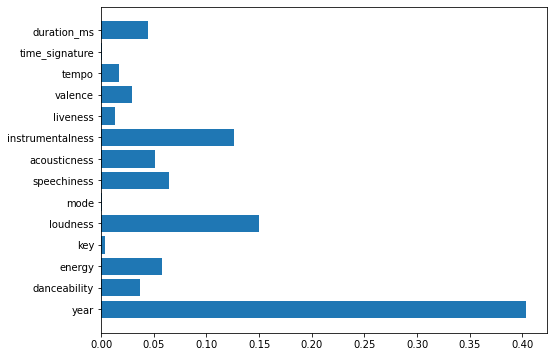

In [49]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_ada.feature_importances_);

Para Ada Boost se puede ver al igual que en  *random search* el peso que tiene el año respecto las demás características.

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [39]:
best_ada.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=60,
                                                         max_features=8,
                                                         max_leaf_nodes=90,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=10,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                               

In [40]:
print("Precisión sobre datos de pruebas: {:.4f}"
      .format(best_ada.score(X_test, y_test)))
print("Precisión sobre datos de train: {:.4f}"
      .format(best_ada.score(X_train, y_train)))

Precisión sobre datos de pruebas: 0.8584
Precisión sobre datos de train: 0.8730


Como se puede observar, respecto de la configuración por defecto se ha conseguido una mejoría de 0.02 en los resultados de test y un incremento en entrenamiento de 0.03. Por tanto hablamos de un modelo más generalizable gracias a la técnica de *cross validation*.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [42]:
filename = '../Models/ada_boost_model_random_year.pkl'

In [32]:
joblib.dump(best_ada, filename)

['../Models/ada_boost_model_random_year.pkl']

In [43]:
best_ada = joblib.load(filename)

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

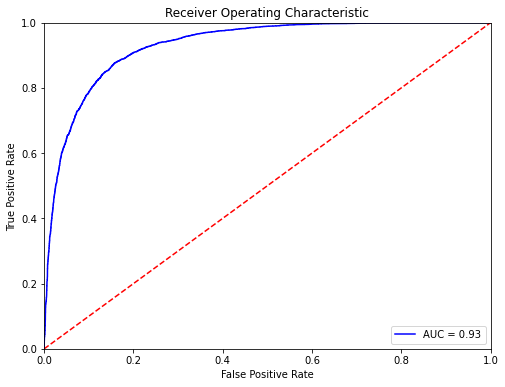

In [44]:
probs = best_ada.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Seguimos obteniendo buenos resultados de AUC=0.93, como era de esperar.

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [58]:
score = best_ada.predict_proba(find_song_year())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 40.3208430965237


## LightGBM
- Realizamos los entrenamientos y análisis de resultados utilizando la implementación de *gradient boosting* de lightgbm

In [84]:
import lightgbm as lgb

In [48]:
lgb_clf =lgb.LGBMClassifier(random_state=32)

In [49]:
%%time
cross_val_score(lgb_clf,X_train,y_train,cv=5).mean()

Wall time: 1.23 s


0.8544955567171982

Al igual que para los 2 casos anteriores, obtenemos un *score* bastante alto en comparación de cuando no teníamos incluido el año como característica.

In [53]:
lgb_clf.fit(X_train,y_train)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=32, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [54]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(lgb_clf.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(lgb_clf.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8586
Precisión sobre el juego de train: 0.8789


In [55]:
filename = '../Models/light_gbm_model_random_year_default.pkl'

In [56]:
joblib.dump(lgb_clf, filename)

['../Models/light_gbm_model_random_year_default.pkl']

- Definimos el *grid* de entrenamiento y se lanza la búsqueda de la mejor combinación de hiperparametros.

In [90]:
boosting_type = ['gbdt','dart']
#Numero de Hojas máximas por árboles
num_leaves = [int(x) for x in np.linspace(30, 110, num = 9)]
# Profundidad de arbol
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
#Learning rate
learning_rate = [round (float(x), 2) for x in np.linspace(0.1, 1., num = 10)]
learning_rate.append(0.005)
learning_rate = sorted(learning_rate)
# Numero de arboles del bosque
n_estimators = [int(x) for x in np.linspace(start = 30, stop = 150, num = 9)]
# Número de muestras para la construcción de contenedores
subsample_for_bin =  list(range(20000, 300000, 20000))
# Reducción mínima de pérdidas para realizar una nueva partición en un nodo del árbol.
min_split_gain =  [0.0,0.2,0.4,0.6,0.8]
#Número mínimo de datos necesarios en una hoja
min_child_samples = [int(x) for x in np.linspace(1, 40, num = 10)]
# reg_alpha
reg_alpha = [round (float(x), 2) for x in np.linspace(0.0, 1., num = 11)]
# reg_lambda
reg_lambda = [round (float(x), 2)  for x in np.linspace(0.0, 1., num = 11)]
# Creacion de cuadrícula aleatoria
param_grid = {'boosting_type':boosting_type,
              'num_leaves': num_leaves,
              'max_depth': max_depth,
              'learning_rate': learning_rate,
              'n_estimators': n_estimators,
              'subsample_for_bin': subsample_for_bin,
              'min_split_gain': min_split_gain,
              'min_child_samples':min_child_samples,
              'reg_alpha':reg_alpha,
              'reg_lambda':reg_lambda}
print(param_grid)

{'boosting_type': ['gbdt', 'dart'], 'num_leaves': [30, 40, 50, 60, 70, 80, 90, 100, 110], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'learning_rate': [0.005, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'n_estimators': [30, 45, 60, 75, 90, 105, 120, 135, 150], 'subsample_for_bin': [20000, 40000, 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000, 220000, 240000, 260000, 280000], 'min_split_gain': [0.0, 0.2, 0.4, 0.6, 0.8], 'min_child_samples': [1, 5, 9, 14, 18, 22, 27, 31, 35, 40], 'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}


In [92]:
lgb_clf = lgb.LGBMClassifier(random_state=32)

In [93]:
light_gbm_random = RandomizedSearchCV(estimator = lgb_clf, param_distributions = param_grid, n_iter = 20000, cv = 5, verbose=2, random_state=32, n_jobs = -1)

In [94]:
light_gbm_random.fit(X_train,y_train)

Fitting 5 folds for each of 20000 candidates, totalling 100000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   55.6s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 16.8min
[Parallel(n_jobs=-1)]: Done 3265 tasks      | elapsed: 21.8min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 4885 tasks      | elapsed: 32.6min
[Parallel(n_jobs=-1)]: Done 5816 tasks      | elapsed: 38.9min
[Parallel(n_jobs=-1)]: Done 6829 tasks      | elapsed: 45.1min
[Parallel(n_jobs=-1)]: Done 7922 tasks      | elapsed: 52.1min
[Parallel(n_jobs=-1)]: Done 9097 tasks      | e

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=32, reg_alpha=0.0,
                                            reg_lambda=0.0, silent...
                                        'num_leaves': [30, 40, 50, 60, 70, 80,
                                              

- Tras la búsqueda de hiperparametros, a continuación se muestra la mejor combinación encontrada, con el *score* obtenido.

In [98]:
light_gbm_random.best_params_

{'subsample_for_bin': 260000,
 'reg_lambda': 0.8,
 'reg_alpha': 0.7,
 'num_leaves': 40,
 'n_estimators': 105,
 'min_split_gain': 0.0,
 'min_child_samples': 31,
 'max_depth': 10,
 'learning_rate': 0.3,
 'boosting_type': 'dart'}

In [96]:
light_gbm_random.best_score_

0.8578410872974386

Hemos conseguido una pequeña mejora respecto al modelo por defecto, una mejora de 0.002.

- A continuación se muestra la importancia que le ha dado el modelo a cada una de las características respecto de las otras.

In [104]:
best_lgb = light_gbm_random.best_estimator_

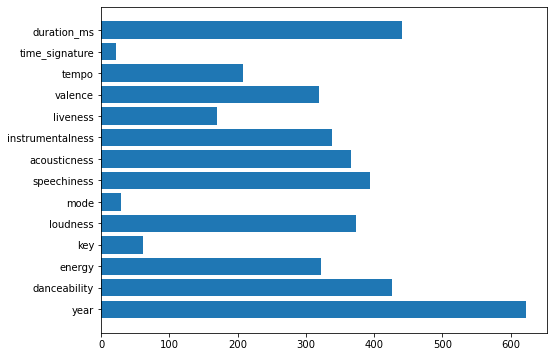

In [105]:
plt.barh(df_songs_year.loc[:,"year":"duration_ms"].columns, best_lgb.feature_importances_);

Para lightGBM podemos observar como la importancia del año respecto las demás características no es tan grande como en los 2 casos anteriores, aun así sigue siendo la característica más importante en nuestro modelo. 

-  Para la configuración obtenida, entrenamos el modelo con todo el dataset de entrenamiento y vemos los resultados obtenidos.

In [106]:
best_lgb.fit(X_train,y_train)

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.3, max_depth=10,
               min_child_samples=31, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=105, n_jobs=-1, num_leaves=40, objective=None,
               random_state=32, reg_alpha=0.7, reg_lambda=0.8, silent=True,
               subsample=1.0, subsample_for_bin=260000, subsample_freq=0)

In [107]:
print("Precisión sobre el juego de pruebas: {:.4f}"
      .format(best_lgb.score(X_test, y_test)))
print("Precisión sobre el juego de train: {:.4f}"
      .format(best_lgb.score(X_train, y_train)))

Precisión sobre el juego de pruebas: 0.8579
Precisión sobre el juego de train: 0.8841


Podemos observar que para la nueva configuración se ha mejorado en *score* con los datos de entrenamiento, y algo peor se obtiene en los resultados para datos de test. Por tanto podríamos tomar ambos modelos, almacenaremos ambos y veremos con cuál nos quedamos según los resultados obtenidos en el cuaderno 4.

- Guardamos nuestro modelo obtenido, para su posterior uso

In [49]:
filename = '../Models/light_gbm_model_random_year.pkl'

In [40]:
joblib.dump(best_lgb, filename)

['../Models/light_gbm_model_random_year.pkl']

In [50]:
best_lgb = joblib.load(filename)

- Representamos la curva ROC para ver de manera visual lo bueno que es nuestro modelo obtenido

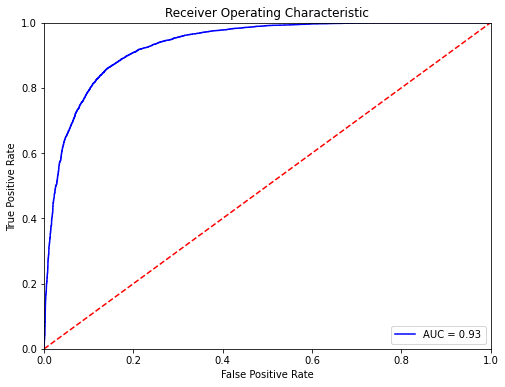

In [51]:
probs = best_lgb.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Seguimos obteniendo buenos resultados de AUC=0.93.

- Utilizando la función definida al principio del cuaderno, podemos hacer predicciones sobre cualquier canción de interés.

In [61]:
score = best_lgb.predict_proba(find_song_year())
print('porcentaje de ser hit:', score[0][1]*100)

Artista: 

 billie eilish


Titulo: 

 bad guy


Canción elegida: bad guy de Billie Eilish
porcentaje de ser hit: 24.24334175021682


## Conclusiones

Tras ver los resultados obtenidos para estos tres modelos, podemos observar que el que mejor resultado obtiene en la clasificación para los datos de test es lightgbm con un 0.8586 seguido de Ada Boost con un 0.8584 y por último *random forest* con un 0.8545. Hemos conseguido resultados para este caso muy parecidos, y superiores en casi 10% con respecto a los modelos que no usaban el año como feature. Pero como hemos comentado esto es una limitación muy importante si se quieren  hacer predicciones en fechas posteriores a 2020, siempre se tomaría esta fecha como corte, ya que no son modelos extrapolables en el tiempo, pero estos modelos si serian capaces de predecir mejor con canciones pasadas para ver si cumplen con la paramétrica de ser *hit*. En el cuaderno 4_model_testing podremos a prueba estos modelos, con canciones actuales y analizaremos cuál es capaz de predecir mejor para canciones actuales.